In [18]:
# Goal: predict Sales using regression trees/related approaches
rm(list=ls())
library(ISLR)          # for Carseats data
library(MASS)          
library(tree)          # regression trees
library(randomForest)  # for randomForest

In [19]:
# Part a: Train/test:
set.seed(1)
fix(Carseats)
num_row     <- nrow(Carseats)      
train_size  <- round(0.7*num_row) 
index       <- sample(1:num_row, train_size) 
# Split into train and test:
train       <- Carseats[index,]
test        <- Carseats[-index,]
print(nrow(train)); print(nrow(test)); print(num_row)

[1] 280
[1] 120
[1] 400



Regression tree:
tree(formula = Sales ~ ., data = train)
Variables actually used in tree construction:
[1] "ShelveLoc"   "Price"       "Age"         "CompPrice"   "Advertising"
[6] "Population"  "Income"     
Number of terminal nodes:  18 
Residual mean deviance:  2.502 = 655.5 / 262 
Distribution of residuals:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-3.74100 -0.98720 -0.02545  0.00000  1.02000  5.06900 


   Bad   Good Medium 
    60     56    164 

[1] 5.3


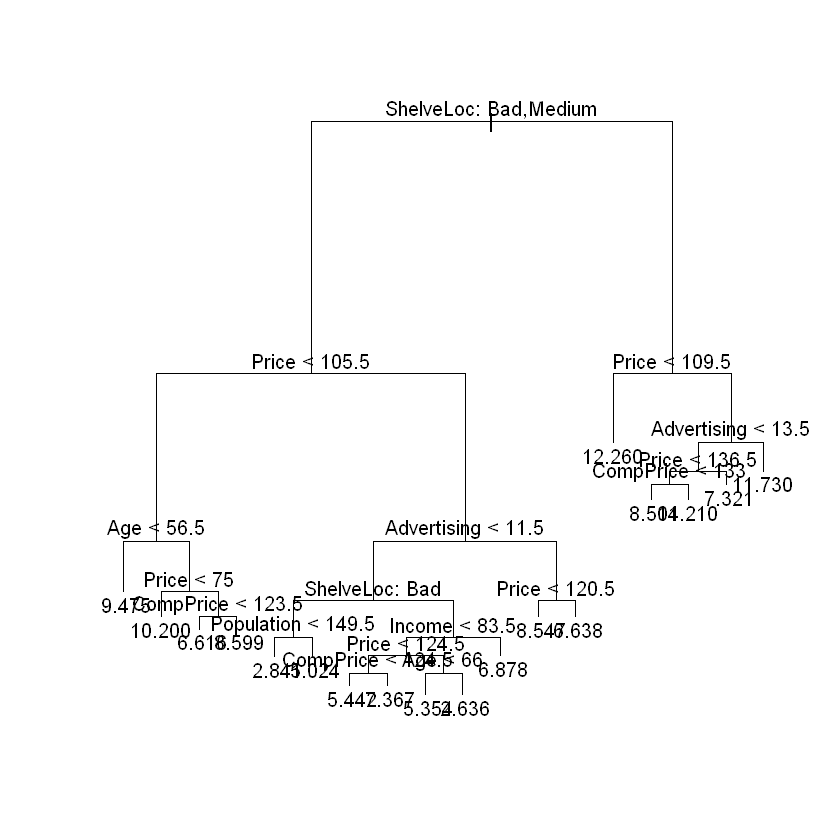

In [20]:
# Part b: Fit a (very large) tree.  Plot tree, and interpret results:
carseats_tree <- tree(Sales~., data=train)
summary(carseats_tree)
plot(carseats_tree)
text(carseats_tree, pretty=0)
table(train$ShelveLoc)
# Predict on test set, and compute MSE:
carseats_tree_preds <- predict(carseats_tree, test)
mse_partb <- mean((test$Sales-carseats_tree_preds)^2)
print(round(mse_partb, 1))
# MSE on test set is 5.3
# Interpret: there is quite a bit of segmentation that this large tree is able
# to find.  Most importantly is the fact if the shelf location is good 
# vs. Medium or Bad.  Next most important in each of the child nodes is
# whether the price is above or below some cut point. Lastly, I suspect this
# tree is overfitting, as it splits many more times on the above two variables
# in addition to CompPrice, Advertising, etc.

[1] 5.1
[1] -0.03


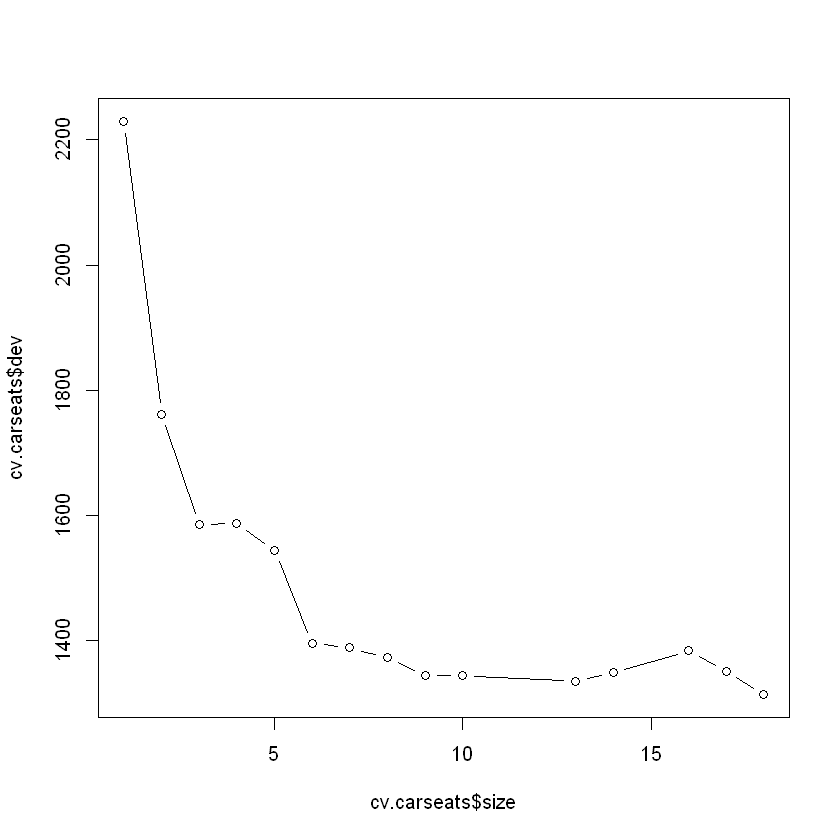

In [21]:
# Part c: Use CV to determine optimal level of tree complexity:
cv.carseats <- cv.tree(carseats_tree)
plot(cv.carseats$size, cv.carseats$dev, type='b')
# print(cv.carseats$size)
# print(cv.carseats$dev)
# CV indicates tree with 9 splits is indicated to be optimal.
prune_tree       <- prune.tree(carseats_tree, best=9)
prune_tree_pred  <- predict(prune_tree, newdata=test)
mse_pruned       <- mean((prune_tree_pred-test$Sales)^2)
print(round(mse_pruned, 1))
print(round(mse_pruned/mse_partb-1, 2))
# Yes, CV reduces test MSE by about 3%. 

In [22]:
# Part d: Bagging
set.seed(2)
mtry_bag        <- (ncol(train)-1)
carseats_bagged <- randomForest(Sales~., data=train, mtry=mtry_bag, importance=TRUE)
carseats_bagged
bag_pred        <- predict(carseats_bagged, newdata=test)
bag_pred_mse    <- mean((bag_pred-test$Sales)^2)
print(round(bag_pred_mse,1))
# Obtain test MSE of 2.4.  This is dramatically lower than test MSE of single tree.
importance(carseats_bagged)
# Both metrics indicate ShelveLoc and Price as the most important predictors.


Call:
 randomForest(formula = Sales ~ ., data = train, mtry = mtry_bag,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 10

          Mean of squared residuals: 2.593248
                    % Var explained: 67.11

[1] 2.4


,%IncMSE,IncNodePurity
CompPrice,28.022452,210.656104
Income,8.455766,109.643329
Advertising,22.528867,183.006939
Population,5.885873,92.487986
Price,65.587241,688.520720
ShelveLoc,67.477471,592.868275
Age,19.192132,205.530720
Education,2.514888,51.929365
Urban,-2.125113,8.783114
US,1.696824,11.024306


In [23]:
# Interlude: build helper function to compute MSE:
mse_machine <- function(predicted, actual)
{
    mse <- mean((predicted-actual)^2)
    return(mse)
}

In [24]:
# Part e: I analyze this data using randomForests for 3 different
# values of mtry:
mtry_vec <- c(3,6,9)
mse_vec <- c(0,0,0)
for (i in 1:length(mtry_vec))
{
    rf         <- randomForest(Sales~., data=train, mtry=mtry_vec[i])
    preds      <- predict(rf, newdata=test)
    mse_vec[i] <- mse_machine(preds, test$Sales)
}

[1] 2.7 2.4 2.3


,IncNodePurity
CompPrice,209.171890
Income,115.695518
Advertising,184.484362
Population,98.981789
Price,678.148007
ShelveLoc,587.875213
Age,202.918148
Education,55.268925
Urban,8.246675
US,12.236266


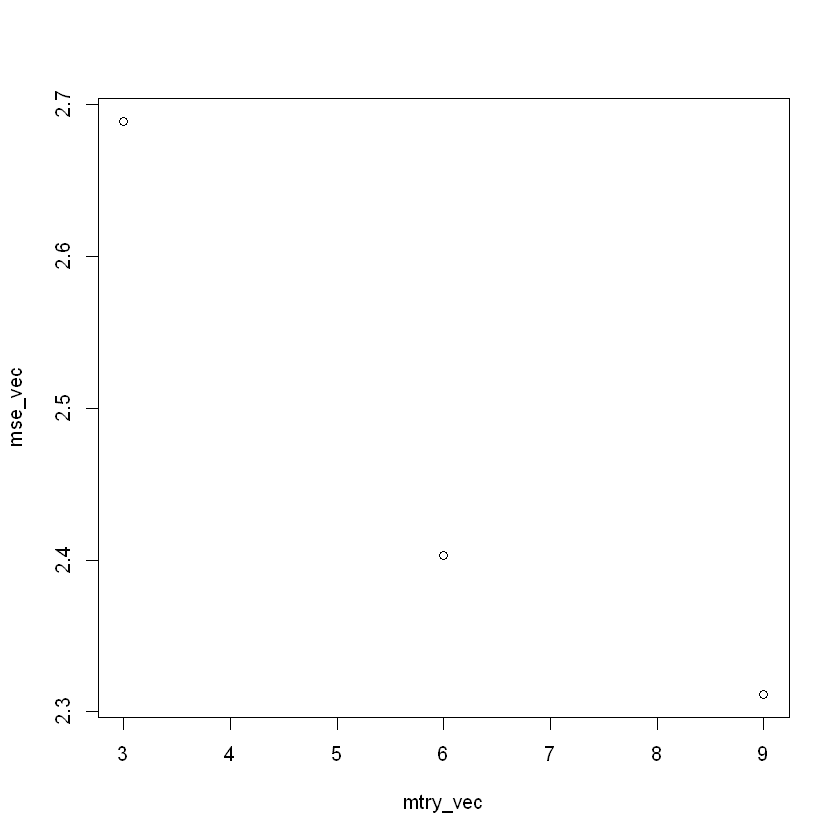

In [17]:
plot(mtry_vec, mse_vec)
print(round(mse_vec,1))
# Obtain MSE values of 2.7, 2.4, and 2.3 for 3, 6, and 9 as values of mtry.
# For these 3 values of mtry, larger values of mtry correspond to smaller
# values of test MSE.
importance(rf)
# Again, Price and ShelveLoc are the most important predictors. 